# Test to make interactive plots with plotly
The (plotly)[https://plotly.com/python/] library boasts that it makes the ploting of interactive graphs easy. Lets test this!

In this test i will attempt to:
 - Plot the distribution of road lenghts as violin plots, cut upon which province the road is in

# 0: Load in data and packages

In [1]:
# Load in relevant packages
import geopandas as gpd
import pandas as pd
import seaborn as sn
import numpy as np
from pathlib import Path
from shapely.geometry import Point, Polygon, MultiPoint, LineString
import plotly
import plotly.express as ex
import plotly.graph_objects as go
from functools import cache
from typing import Union


# Load in the data and inspect in
# Load a shape file of world lakes as a GeoDataFrame:
path_roman_roads_split = Path(
    "C:\\Users\\mlind\\github\\Minerva_hackathon\\data\\split segments\\road_merge_split_08112023.shp"
)
roman_roads: gpd.GeoDataFrame = gpd.read_file(path_roman_roads_split)

# We need to save the projection and the units used for the geometry for future reference
projection_roman_roads = roman_roads.crs
units_roman_roads = roman_roads.crs.axis_info[0].unit_name

# We load in the provinces data
path_to_provinces_geojson = Path(
    "C:\\Users\\mlind\\github\\Minerva_hackathon\\data\\provinces_valid.geojson"
)
roman_provinces: gpd.GeoDataFrame = gpd.read_file(path_to_provinces_geojson)

projection_provinces = roman_provinces.crs
units_provinces = roman_provinces.crs.axis_info[0].unit_name

# We check out the projection and units of the geometries of the different objects
print(projection_provinces, projection_roman_roads, units_provinces, units_roman_roads)

# we get the type of the roads
print(type(roman_roads["geometry"][0]))
print(len(roman_provinces['province']))

EPSG:3035 EPSG:3395 metre metre
<class 'shapely.geometry.linestring.LineString'>
61


# 1: Prepare the data

In [2]:
print(
    projection_provinces,
    projection_roman_roads,
    "The projections are not the same so we need to change the provinces projection to match the on of the roads",
)

# cast the provinces. By doing this we re-project all of the points. I think this i desirable?
roman_provinces.to_crs(crs=projection_roman_roads, inplace=True)

# update variables
projection_provinces = roman_provinces.crs
units_provinces = roman_provinces.crs.axis_info[0].unit_name

print(
    projection_provinces,
    projection_roman_roads,
    "The projections are now the same, yay!",
)

roman_roads_length_gpd = gpd.GeoDataFrame(
    data={"length": roman_roads["geometry"].length, "name": roman_roads["Name"]},
    geometry=roman_roads["geometry"],
)


# Now, we need to split the roads dataframe based on the geometry of the provinces. We define a costum function for it
def find_province_for_road(geometry_road: LineString):
    for _, province in roman_provinces.iterrows():
        # If a roadsegment is entirely inside a province, then it belongs to that province
        if geometry_road.within(province["geometry"]):
            return province["province"]
    possible_provinces = []
    # If a roadsegment is not contained within a province, we instead try to figure out which provinces it crosses and return the first one we find
    # TODO This part of the code is fucked and doesnt work, save it and come back to it later
    # for _, province in roman_provinces.iterrows():
    #     if geometry_road.crosses(province["geometry"]):
    #         possible_provinces.append(province["province"])
    # return possible_provinces[0] if len(possible_provinces) > 0 else None


roman_roads_length_gpd["province"] = roman_roads_length_gpd["geometry"].map(
    find_province_for_road
)
print(len(roman_provinces['province']))

EPSG:3035 EPSG:3395 The projections are not the same so we need to change the provinces projection to match the on of the roads
EPSG:3395 EPSG:3395 The projections are now the same, yay!
61


In [3]:
# Calculate the difference between max and min length within each province and use it to sort the violin plots by
roads_missing_provinces: gpd.GeoDataFrame = roman_roads_length_gpd.loc[
    roman_roads_length_gpd["province"].isna()
]
print(
    f"There are {len(roads_missing_provinces)/len(roman_roads_length_gpd) * 100}% of roads which we have not been able to assign a province"
)
print("Not bad")

# WE fill in NA values with 0 since we need to be able to do a logical test on them
roman_roads_length_gpd.fillna(value={"length": 0}, inplace=True)

# We replace all roads in the coloumn that are below 1 m long with NA
roman_roads_length_gpd["length"] = [
    length if length >= 1 else pd.NA for length in roman_roads_length_gpd["length"]
]

# We drop NA values
roman_roads_length_gpd_no_na = roman_roads_length_gpd.dropna(axis=0, how="any")

# We make a new length in km column
roman_roads_length_gpd_no_na["length (km)"] = (
    roman_roads_length_gpd_no_na["length"] / 1000
)


# we print how many values we have removed
print(
    f"We still have {(len(roman_roads_length_gpd_no_na) / len(roman_roads_length_gpd)) * 100}% of the dataset due to either no province for the road being found or the road segment is less than 1 m"
)
print(roads_missing_provinces)
print(len(roman_provinces['province']))

There are 8.198068625436614% of roads which we have not been able to assign a province
Not bad
We still have 91.21977946715978% of the dataset due to either no province for the road being found or the road segment is less than 1 m
              length                      name  \
1       98678.644750       Fanum Fortunae-Rome   
8       22962.797789              Rome-Aretium   
12      41849.827286           Populonium-Rome   
21     143724.062049  Metapontum-Nares Lucanae   
31      58600.649622              Aternum-Buca   
...              ...                       ...   
14546   48269.811617       Germanicea-Samosata   
14560   54817.993373        Antioch-Germanicea   
14570  248853.941831        Soura-Dura Europos   
14573  181085.812075          Oresa-Callinicum   
14574  289253.301174      Palmyra-Dura Europos   

                                                geometry province  
1      LINESTRING (1393279.923 5209929.068, 1393489.0...     None  
8      LINESTRING (1378264.403 5

c:\Users\mlind\AppData\Local\pypoetry\Cache\virtualenvs\minerva-hackathon-BUbf-Wbk-py3.11\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# 2: Plot the data

In [4]:
# We make a violin plot of all roads an save it
# TODO: Try to rank the graphs by different characteristics, like largest observation, largest difference between top and bottom
# TODO: color the plots by the size of the polygon and rank them by some other feature, f.eks. the difference between min and max observation
# TODO: Normalise the data and try to see how that changes the plots and makes it easier to compare the provinces
# TODO: Split the provinces in west and east and compare them in overlay mode and split mode
# We sort the dataframe based on the largest observation for each province

violin_all = ex.violin(
    roman_roads_length_gpd_no_na,
    y="length (km)",
    title="Length distribution of all line segments in the roman roads split dataset",
    labels={"y": "Length of road segment in KM"},
    points="all",
    range_y=[0, 500],
)

violin_all.write_html(
    "C:\\Users\\mlind\\github\\Minerva_hackathon\\plots\\violin_all_roman_roads.html"
)
print(len(roman_provinces['province']))

61


In [5]:
# We now make a violin plot split along wich region the segment is in
violin_all_split_on_province_rank_on_top_observations = ex.violin(
    roman_roads_length_gpd_no_na,
    y="length (km)",
    x="province",
    title="Length distribution of all line segments in the roman roads split dataset, split on province",
    labels={"y": "Length of road segment in KM"},
    range_y=[0, 500],
    width=20000,
)

# Sort the violin plots by the max length within each group
sorted_provinces = (
    roman_roads_length_gpd_no_na.groupby("province")["length"]
    .max()
    .sort_values(ascending=False)
    .index
)
violin_all_split_on_province_rank_on_top_observations.update_xaxes(
    categoryorder="array", categoryarray=sorted_provinces
)
violin_all_split_on_province_rank_on_top_observations.write_html(
    "C:\\Users\\mlind\\github\\Minerva_hackathon\\plots\\violin_split_on_province_ranked_on_top_observation.html"
)
print(len(roman_provinces['province'].unique()))
print(len(roman_roads_length_gpd_no_na['province'].unique()))

61
56


In [6]:

province_diff = (
    roman_roads_length_gpd_no_na.groupby("province")["length"]
    .apply(lambda x: x.max() - x.min())
    .reset_index(name="length_diff")
)


# Merge the calculated differences with the original DataFrame
df = pd.merge(roman_roads_length_gpd_no_na, province_diff, on="province")
# rename the index for clarity
df.index.set_names(names="ID", inplace=True)

# we make a new dataframe were the provinces are the indexes, this allows us to use the .loc function to find a row where a specific province is defined
roman_provinces_index_province = roman_provinces.copy(deep=True)
roman_provinces_index_province['area'] = roman_provinces['geometry'].area
roman_provinces_index_province = roman_provinces_index_province.set_index('province')

# Sort the DataFrame by the calculated length difference
df.sort_values(by="length_diff", inplace=True, ascending=False)
# iterate over each row an make a new dataframe with data about the shape and size of the province of the road belongs to
df_size_of_province_per_route = pd.DataFrame(columns=["ID", "area"])
for index, row in df.iterrows():
    province = row['province']
    area = roman_provinces_index_province.loc[province, 'area']
    data = pd.Series({"ID" : index, "area": area})
    df_size_of_province_per_route = pd.concat([df_size_of_province_per_route, data.to_frame().T], ignore_index=True)

df = pd.merge(left=df, right=df_size_of_province_per_route, left_index=True, right_index=True)

# Create a figure with multiple violin plots arranged by the length difference
print('made it!')
violin_all_split_on_province_rank_on_biggest_diff = ex.violin(
    data_frame=df,
    y="length (km)",
    x="province",
    color="area",
    title="Length distribution of all line segments in the roman roads split dataset, split on province",
    labels={"y": "Length of road segment in KM"},
    range_y=[0, 500],
    width=20000,
)

violin_all_split_on_province_rank_on_biggest_diff

# violin_all_split_on_province_rank_on_biggest_diff.write_html(
#     "C:\\Users\\mlind\\github\\Minerva_hackathon\\plots\\violin_all_split_on_province_rank_on_biggest_diff.html"
# )

C:\Users\mlind\AppData\Local\Temp\ipykernel_13592\1674321277.py:26: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



made it!


In [8]:
roman_provinces_index_province.index

Index(['Achaia', 'Alpes Poeninae', 'Alpes Graiae', 'Umbria (Regio VI)',
       'Picenum (Regio V)', 'Samnium (Regio IV)',
       'Latium et Campania (Regio I)', 'Etruria (Regio VII)',
       'Transpadana (Regio XI)', 'Liguria (Regio IX)', 'Aemilia (Regio VIII)',
       'Alpes Cottiae', 'Alpes Maritimae', 'Venetia et Histria (Regio X)',
       'Bruttium et Lucania (Regio III)', 'Sicilia', 'Sardinia', 'Corsica',
       'Apulia et Calabria (Regio II)', 'Asia', 'Britannia', 'Creta', 'Cyprus',
       'Germania Superior', 'Belgica', 'Narbonensis', 'Aquitania',
       'Lugdunensis', 'Germania Inferior', 'Lusitania', 'Baetica', 'Assyria',
       'Armenia', 'Lycia et Pamphylia', 'Bithynia et Pontus', 'Mesopotamia',
       'Galatia', 'Cappadocia', 'Cilicia', 'Macedonia', 'Epirus',
       'Hispania Citerior', 'Noricum', 'Pannonia Inferior',
       'Pannonia Superior', 'Cyrene', 'Aegyptus', 'Mauretania Caesariensis',
       'Numidia', 'Africa Proconsularis', 'Mauretania Tingitana', 'Raetia',
     

In [ ]:
# # Get the 5 provinces with the most roads
# top_5_provinces = roman_roads_length_gpd_no_na["province"].value_counts().head(5)
# fig = go.Figure()

# df = roman_roads_length_gpd_no_na.copy()


# for province in top_5_provinces:
#     fig.add_trace(
#         go.Violin(
#             x=df["province"][df["province"] == province],
#             y=df["length"][df["province"] == province],
#             name=province,
#             box_visible=True,
#             meanline_visible=True,
#         )
#     )

# fig.show()

# violin_all.write_html("C:\\Users\\mlind\\github\\Minerva_hackathon\\plots\\violin_all_roman_roads.html")

<Axes: >

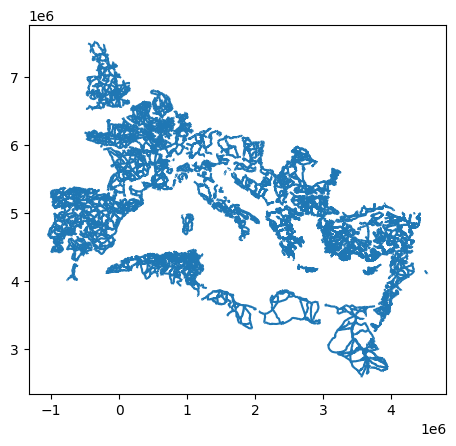

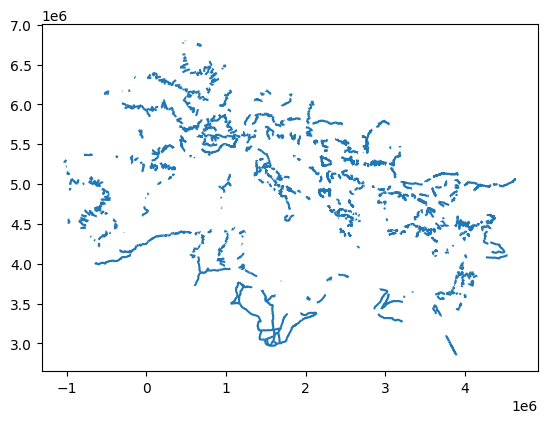

In [ ]:
roman_roads_length_gpd_no_na.plot()
roads_missing_provinces.plot()
# TODO: Remove Messopatamia, Armenia, Assyria. Whatever is assigned to messopotamia needs to be assigned to syria. And that which is assigned to Armenia should be assigned to cappadosia.The roads to the top rigth can be included in Dacia.